In [1]:
%pylab inline

%pylab is deprecated, use %matplotlib inline and import the required libraries.
Populating the interactive namespace from numpy and matplotlib


In [2]:
import pandas as pd

In [3]:
from ase.build import bulk

In [4]:
from ase.optimize import BFGS, FIRE
from ase.filters import FrechetCellFilter

In [5]:
from ase.phonons import Phonons

In [6]:
import os

In [7]:
# os.environ['CUDA_VISIBLE_DEVICES']='-1' # to disable GPU usage
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

In [8]:
from tensorpotential.calculator import TPCalculator

[tensorpotential] Info: Environment variable TF_USE_LEGACY_KERAS is automatically set to '1'.


E0000 00:00:1772279500.694853 1187986 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1772279500.698231 1187986 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1772279500.707173 1187986 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1772279500.707182 1187986 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1772279500.707183 1187986 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1772279500.707184 1187986 computation_placer.cc:177] computation placer already registered. Please check linka

# Load TPCalculator

In [9]:
calc=TPCalculator("../1-fit/seed/1/final_model//")

In [10]:
al=bulk('Al')

In [11]:
al.calc=calc

In [12]:
al.get_potential_energy()

I0000 00:00:1772279510.286904 1187986 service.cc:152] XLA service 0x17fdf7b0 initialized for platform Host (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1772279510.286937 1187986 service.cc:160]   StreamExecutor device (0): Host, Default Version
I0000 00:00:1772279511.876594 1187986 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


np.float64(-3.752409566331133)

In [13]:
BFGS(FrechetCellFilter(al)).run()

      Step     Time          Energy          fmax
BFGS:    0 12:51:51       -3.752410        0.010082


np.True_

In [14]:
li=bulk('Li')

In [15]:
li.calc=calc

In [16]:
li.get_potential_energy()

np.float64(-1.9116369755541551)

In [17]:
BFGS(FrechetCellFilter(li)).run()

      Step     Time          Energy          fmax
BFGS:    0 12:51:52       -1.911637        0.108903
BFGS:    1 12:51:52       -1.912125        0.100407
BFGS:    2 12:51:52       -1.915093        0.011487


np.True_

# Phonons

Example from https://wiki.fysik.dtu.dk/ase/ase/phonons.html

## Al

In [18]:
! rm -rf phonon/

In [19]:
# Phonon calculator
N = 7
ph = Phonons(al, calc, supercell=(N, N, N), delta=0.05)
ph.run()

In [20]:
# Read forces and assemble the dynamical matrix
ph.read(acoustic=True)
ph.clean()

7

In [21]:
path = al.cell.bandpath( npoints=100)
bs = ph.get_band_structure(path)

dos = ph.get_dos(kpts=(20, 20, 20)).sample_grid(npts=100, width=1e-3)

WARNING, 2 imaginary frequencies at q = ( 0.00,  0.00,  0.00) ; (omega_q = 1.453e-08*i)
WARNING, 2 imaginary frequencies at q = ( 0.00,  0.00,  0.00) ; (omega_q = 1.453e-08*i)


Text(0.5, 0, 'DOS')

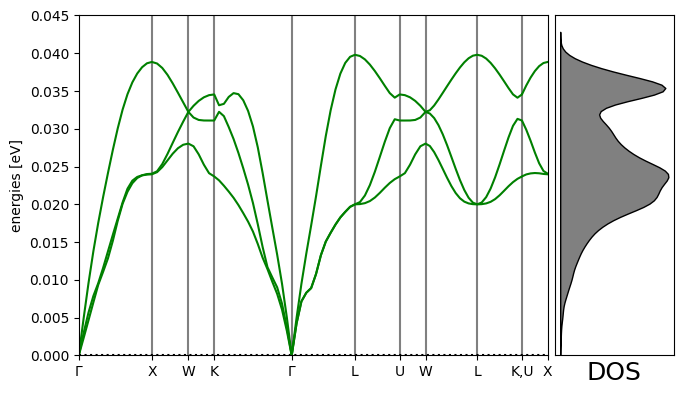

In [22]:
fig = plt.figure(1, figsize=(7, 4))
ax = fig.add_axes([.12, .07, .67, .85])

emax = 0.045
bs.plot(ax=ax, emin=0.0, emax=emax)

dosax = fig.add_axes([.8, .07, .17, .85])
dosax.fill_between(dos.get_weights(), dos.get_energies(), y2=0, color='grey',
                   edgecolor='k', lw=1)

dosax.set_ylim(0, emax)
dosax.set_yticks([])
dosax.set_xticks([])
dosax.set_xlabel("DOS", fontsize=18)

## Li

In [23]:
! rm -rf phonon/

In [24]:
# Phonon calculator
N = 7
ph = Phonons(li, calc, supercell=(N, N, N), delta=0.05)
ph.run()

# Read forces and assemble the dynamical matrix
ph.read(acoustic=True)
ph.clean()

7

In [25]:
path = li.cell.bandpath( npoints=100)
bs = ph.get_band_structure(path)

dos = ph.get_dos(kpts=(20, 20, 20)).sample_grid(npts=100, width=1e-3)

WARNING, 2 imaginary frequencies at q = ( 0.00,  0.00,  0.00) ; (omega_q = 2.233e-08*i)
WARNING, 2 imaginary frequencies at q = ( 0.00,  0.00,  0.00) ; (omega_q = 2.233e-08*i)


Text(0.5, 0, 'DOS')

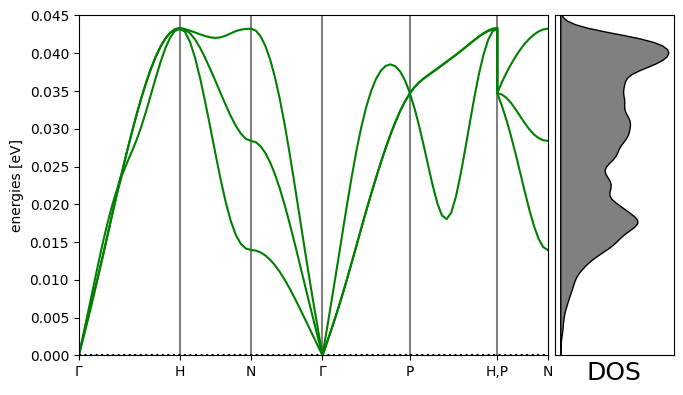

In [26]:
fig = plt.figure(1, figsize=(7, 4))
ax = fig.add_axes([.12, .07, .67, .85])

emax = 0.045
bs.plot(ax=ax, emin=0.0, emax=emax)

dosax = fig.add_axes([.8, .07, .17, .85])
dosax.fill_between(dos.get_weights(), dos.get_energies(), y2=0, color='grey',
                   edgecolor='k', lw=1)

dosax.set_ylim(0, emax)
dosax.set_yticks([])
dosax.set_xticks([])
dosax.set_xlabel("DOS", fontsize=18)

# Ensemble calculator

In [27]:
calc_ens=TPCalculator(model=[
            "../1-fit/seed/1/final_model/",
             "../1-fit/seed/2/final_model/",
             "../1-fit/seed/3/final_model/",
    ]
)

In [28]:
element="Al"

In [29]:
a_list=np.linspace(1.0, 8, num=75)

energy_list=[]
estd_list=[]

for a in a_list:
    at = bulk(element,"fcc",a=a)
    at.calc=calc_ens
    
    e=at.get_potential_energy()
    estd=at.calc.results['energy_std']
    
    energy_list.append(e)
    estd_list.append(estd)

In [30]:
estd_list=np.array(estd_list)
energy_list=np.array(energy_list)

In [31]:
e_std_threshold = 10.e-3

In [32]:
mask = estd_list<e_std_threshold

np.float64(0.001)

Text(0, 0.5, 'E-std, eV/atom')

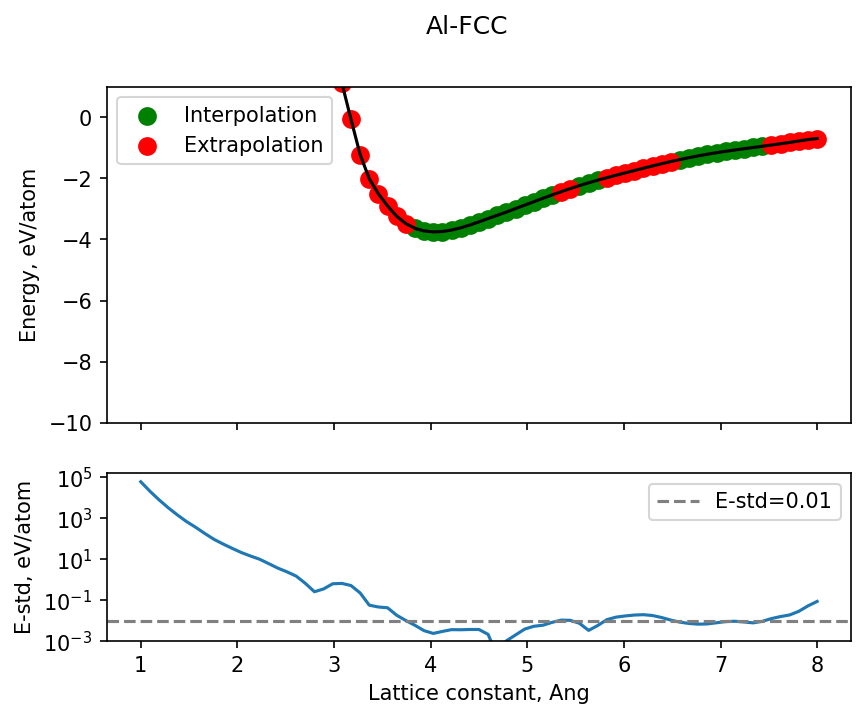

In [37]:
fig, axs= plt.subplots(nrows=2, ncols=1, sharex=True, height_ratios = [2,1], dpi=150)

fig.suptitle(element+"-FCC")
#### energy ###
axs[0].plot(a_list, energy_list, color='black')
axs[0].scatter(a_list[mask], energy_list[mask], lw=3, color="green", label='Interpolation')
axs[0].scatter(a_list[~mask], energy_list[~mask], lw=3, color="red", label='Extrapolation')

axs[0].legend()
# axs[0].set_yscale('symlog')
axs[0].set_ylabel("Energy, eV/atom")
axs[0].set_ylim(-10,1)
#### gamma ###
axs[1].plot(a_list, estd_list)
axs[1].set_yscale('log');
axs[1].set_xlabel("Lattice constant, Ang")


axs[1].axhline(e_std_threshold, ls='--', color='gray', label=f'E-std={e_std_threshold}')
axs[1].legend()
axs[1].set_ylim(min([0.1, 0.1*e_std_threshold]), None)
axs[1].set_ylabel("E-std, eV/atom")